In [57]:
# Import Libraries
from keras_facenet import FaceNet
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from datasets import Dataset, load_dataset, load_from_disk
import tensorflow as tf
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from PIL import ImageEnhance, ImageFilter, ImageOps
from datasets import load_dataset, Dataset, ClassLabel, Features, Image, concatenate_datasets, Value
from tqdm import tqdm
import random

In [ ]:
# Load in Datasets

# Jenna 
jenna = load_dataset("Jenna")
jenna = jenna['train'].map(lambda example: {"labels": 1})

# Not Jenna 
not_jenna = load_dataset("Not Jenna")
not_jenna = not_jenna["train"].map(lambda example: {"labels": 0})

# Random Faces
random_faces = load_from_disk("ds_zero_labels")
random_faces = random_faces.cast_column("labels", Value("int64"))

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
# Define a random augmentation function for face images
def random_augmentation(image):
    # Random horizontal flip with 50% probability
    if random.random() < 0.5:
        image = ImageOps.mirror(image)
    
    # Random brightness adjustment: scale brightness between 0.8 and 1.2
    enhancer = ImageEnhance.Brightness(image)
    brightness_factor = random.uniform(0.8, 1.2)
    image = enhancer.enhance(brightness_factor)
    
    # Random rotation between -15 and 15 degrees
    angle = random.uniform(-15, 15)
    image = image.rotate(angle)
    
    return image


Augmented dataset size: 1300


In [35]:
# Initialize lists to store augmented images and labels
augmented_images = []
augmented_labels = []

# For each image in ds_pos, generate 100 augmented samples
for example in jenna:
    original_image = example["image"]
    for _ in range(50):  
        new_image = random_augmentation(original_image)
        augmented_images.append(new_image)
        augmented_labels.append(example["labels"])

# Create a new dataset from the augmented images and labels
jenna_augmented = Dataset.from_dict({
    "image": augmented_images,
    "labels": augmented_labels
})

print(f"Augmented dataset size: {len(jenna_augmented)}")

Augmented dataset size: 1300


In [36]:
# Initialize lists to store augmented images and labels
augmented_images = []
augmented_labels = []

# For each image in ds_pos, generate 100 augmented samples
for example in not_jenna:
    original_image = example["image"]
    for _ in range(50):  
        new_image = random_augmentation(original_image)
        augmented_images.append(new_image)
        augmented_labels.append(example["labels"])

# Create a new dataset from the augmented images and labels
not_jenna_augmented = Dataset.from_dict({
    "image": augmented_images,
    "labels": augmented_labels
})

print(f"Augmented dataset size: {len(not_jenna_augmented)}")

Augmented dataset size: 1200


In [40]:
# Balance Zero Dataset
ran_indices = random.sample(range(len(random_faces)), min(len(not_jenna_augmented), len(random_faces)))
not_jenna_augmented = not_jenna_augmented.select(ran_indices)
random_faces = random_faces.select(ran_indices)

In [43]:
# Final Datasets
label_one = jenna_augmented
label_zero = concatenate_datasets([not_jenna_augmented, random_faces])

In [45]:
# Combine Datasets and Randomly Sample 
print(f"Label One Length: {len(label_one)}")
print(f"Label Zero Length: {len(label_zero)}")

ran_indices = random.sample(range(len(label_one)), min(len(label_zero), len(label_one)))

final_one = label_one.select(ran_indices)
final_zero = label_zero.select(ran_indices)

balanced_dataset = concatenate_datasets([final_one, final_zero])

print(f"Balanced Dataset Length: {len(balanced_dataset)}")

Label One Length: 1300
Label Zero Length: 2000
Balanced Dataset Length: 2600


In [46]:
# Train-Test Split
train_test = balanced_dataset.train_test_split(test_size=0.2, seed=42)
train_val_ds = train_test["train"]
test_ds = train_test["test"]

# Train-Validation Split
train_val = train_val_ds.train_test_split(test_size=0.2, seed=42)
train_ds = train_val["train"]
val_ds = train_val["test"]

In [47]:
# Split into X and Y
target_size = (224, 224)

X_train = np.array([np.array(img.resize(target_size)) for img in train_ds["image"]])
Y_train = np.array(train_ds["labels"])

X_val = np.array([np.array(img.resize(target_size)) for img in val_ds["image"]])
Y_val = np.array(val_ds["labels"])

X_test = np.array([np.array(img.resize(target_size)) for img in test_ds["image"]])
Y_test = np.array(test_ds["labels"])

In [48]:
# Model Summary
embedder = FaceNet()
base_model = embedder.model

# Add Binary Classification Layer
x = base_model.output
classification_output = Dense(1, activation='sigmoid', name='classification_layer')(x)
model = Model(inputs=base_model.input, outputs=classification_output)

# Freeze Base Model Layers
for layer in base_model.layers:
    layer.trainable = False

# Compile Last Layer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fit the model
model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_data=(X_val, Y_val))

# Evaluate Model Before Fine-Tuning
print(f"Before fine-tuning, the model achieved an accuracy of: {model.evaluate(X_test, Y_test)[1] * 100:.2f}%")

Epoch 1/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 54s 969ms/step - accuracy: 0.4810 - loss: 0.6942 - val_accuracy: 0.5986 - val_loss: 0.6896
Epoch 2/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 50s 955ms/step - accuracy: 0.5644 - loss: 0.6900 - val_accuracy: 0.5649 - val_loss: 0.6865
Epoch 3/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 47s 911ms/step - accuracy: 0.5618 - loss: 0.6867 - val_accuracy: 0.5288 - val_loss: 0.6844
Epoch 4/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 47s 916ms/step - accuracy: 0.5793 - loss: 0.6820 - val_accuracy: 0.6178 - val_loss: 0.6790
Epoch 5/5
52/52 ━━━━━━━━━━━━━━━━━━━━ 47s 914ms/step - accuracy: 0.5732 - loss: 0.6806 - val_accuracy: 0.6178 - val_loss: 0.6751
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 695ms/step - accuracy: 0.5797 - loss: 0.6825
Before fine-tuning, the model achieved an accuracy of: 58.85%


In [49]:
# Unfreeze All Layers
for layer in model.layers:
    layer.trainable = True

# Re-Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-Tune
model.fit(X_train, Y_train, epochs=3, batch_size=32, validation_data=(X_val, Y_val))

# Evaluate Model Before Fine-Tuning
print(f"After fine-tuning, the model achieved an accuracy of: {model.evaluate(X_test, Y_test)[1] * 100:.2f}%")

Epoch 1/3
52/52 ━━━━━━━━━━━━━━━━━━━━ 258s 5s/step - accuracy: 0.8192 - loss: 0.5637 - val_accuracy: 0.7188 - val_loss: 0.5964
Epoch 2/3
52/52 ━━━━━━━━━━━━━━━━━━━━ 232s 4s/step - accuracy: 1.0000 - loss: 0.3019 - val_accuracy: 0.9207 - val_loss: 0.3373
Epoch 3/3
52/52 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - accuracy: 0.9997 - loss: 0.2282 - val_accuracy: 0.9784 - val_loss: 0.2463
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 760ms/step - accuracy: 0.9537 - loss: 0.2679
After fine-tuning, the model achieved an accuracy of: 96.54%


17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 865ms/step


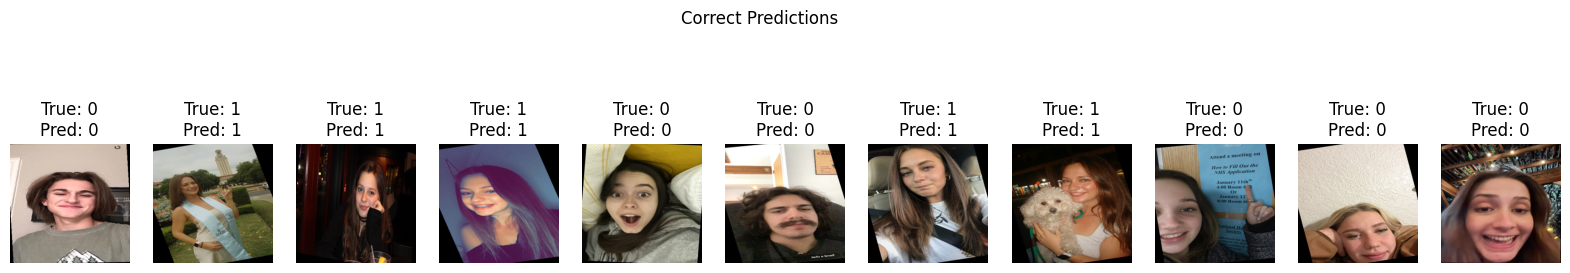

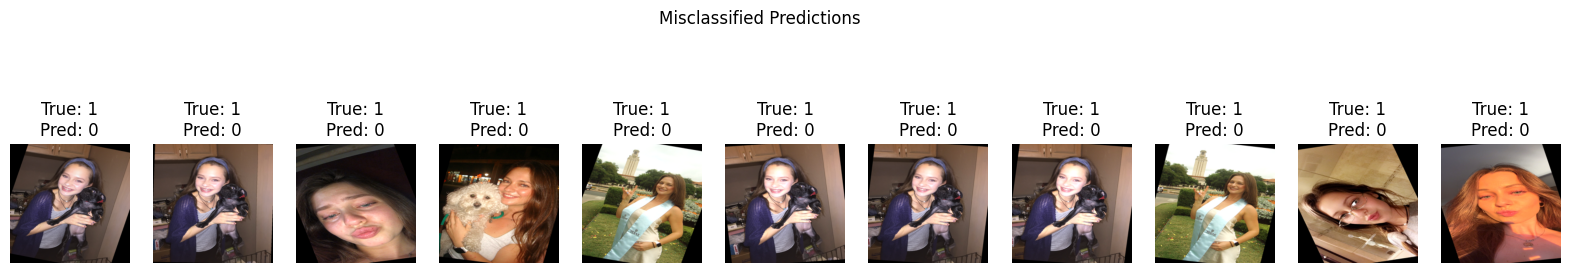

Number of Correctly Classified Cases: 509
Percent of Correctly Classified Cases: 97.88%
Number of Incorrectly Classified Cases: 11
Percent of Incorrectly Classified Cases: 2.12%


In [50]:
# Generate Predictions
predictions = model.predict(X_test)
pred_classes = (predictions > 0.8).astype(int).flatten()

# Find indices for correct and incorrect predictions
correct_indices = np.where(pred_classes == Y_test)[0]
wrong_indices = np.where(pred_classes != Y_test)[0]

# Plot Function
def plot_examples(indices, title, num_examples=11):
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(indices[:num_examples]):
        plt.subplot(1, num_examples, i+1)
        plt.imshow(X_test[idx])
        plt.title(f"True: {Y_test[idx]}\nPred: {pred_classes[idx]}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Correctly Classified Examples
plot_examples(correct_indices, "Correct Predictions")

# Incorrectly Classified Examples
plot_examples(wrong_indices, "Misclassified Predictions")

# Correct Cases
print(f"Number of Correctly Classified Cases: {len(correct_indices)}")
print(f"Percent of Correctly Classified Cases: {len(correct_indices) / (len(correct_indices) + len(wrong_indices)) * 100:.2f}%")
print(f"Number of Incorrectly Classified Cases: {len(wrong_indices)}")
print(f"Percent of Incorrectly Classified Cases: {len(wrong_indices) / (len(correct_indices) + len(wrong_indices)) * 100:.2f}%")


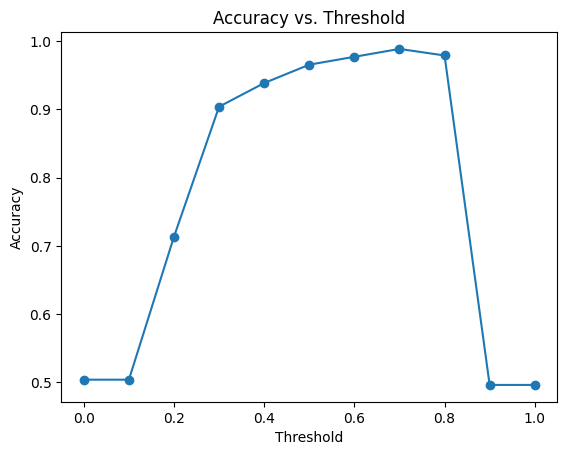

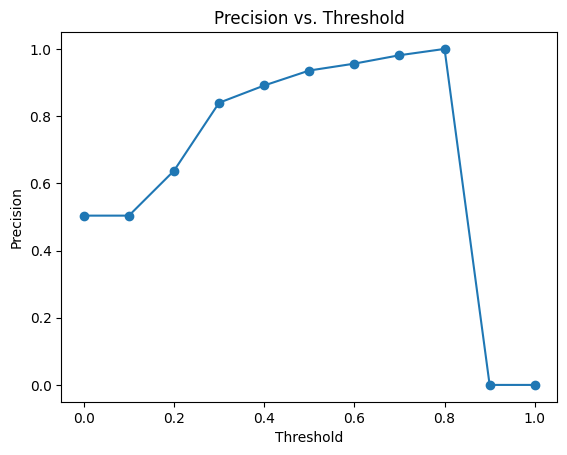

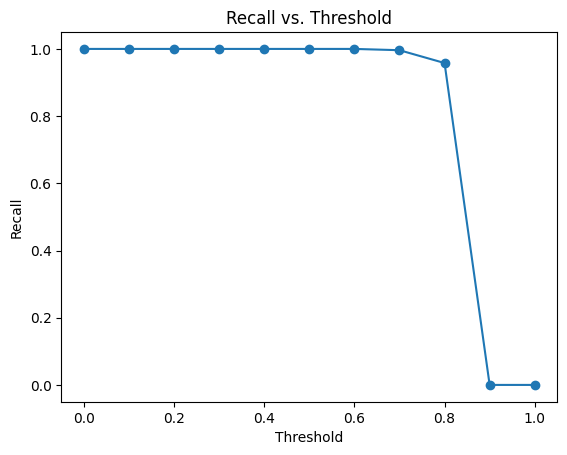

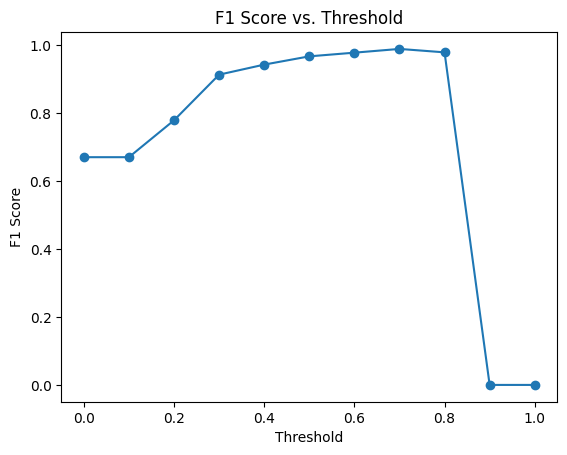

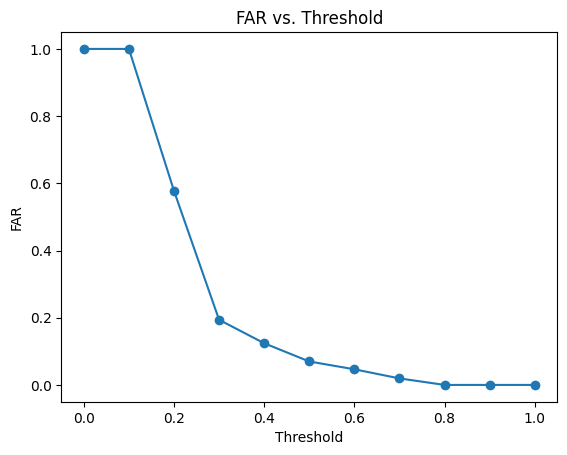

In [ ]:
thresholds = np.linspace(0, 1, 11)  # 0.0, 0.1, 0.2, ..., 1.0

accuracies = []
precisions = []
recalls = []
f1_scores = []
fars = []  # We'll store FAR here

for thr in thresholds:
    # Binarize predictions
    pred_classes = (predictions > thr).astype(int).flatten()
    
    # Calculate typical metrics
    acc = accuracy_score(Y_test, pred_classes)
    prec = precision_score(Y_test, pred_classes, zero_division=0)
    rec = recall_score(Y_test, pred_classes, zero_division=0)
    f1 = f1_score(Y_test, pred_classes, zero_division=0)
    
    # Get confusion matrix to compute FAR
    tn, fp, fn, tp = confusion_matrix(Y_test, pred_classes).ravel()
    far = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    fars.append(far)

# Plot Accuracy vs. Threshold
plt.figure()
plt.plot(thresholds, accuracies, marker='o')
plt.title('Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

# Plot Precision vs. Threshold
plt.figure()
plt.plot(thresholds, precisions, marker='o')
plt.title('Precision vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

# Plot Recall vs. Threshold
plt.figure()
plt.plot(thresholds, recalls, marker='o')
plt.title('Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()

# Plot F1 Score vs. Threshold
plt.figure()
plt.plot(thresholds, f1_scores, marker='o')
plt.title('F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.show()

# Plot FAR vs. Threshold
plt.figure()
plt.plot(thresholds, fars, marker='o')
plt.title('FAR vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('FAR')
plt.show()


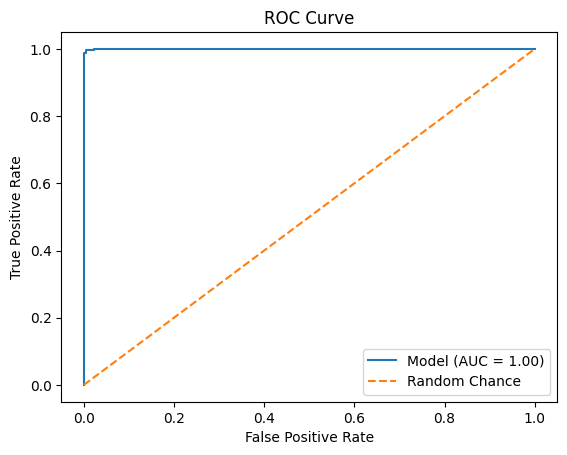

In [60]:
# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(Y_test, predictions)

# Compute AUC
roc_auc = roc_auc_score(Y_test, predictions)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"Model (AUC = {roc_auc:.2f})")

# Plot the 45-degree line (represents a random classifier)
plt.plot([0, 1], [0, 1], '--', label="Random Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


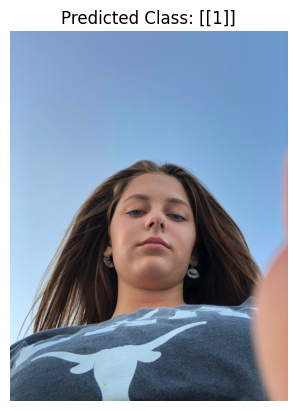

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


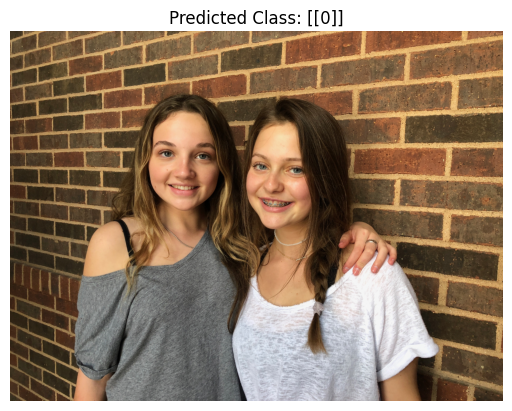

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


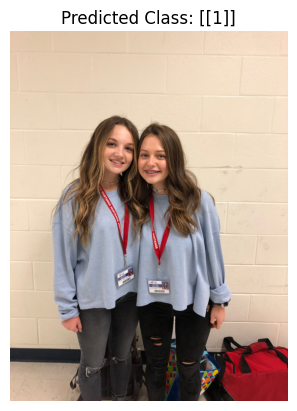

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


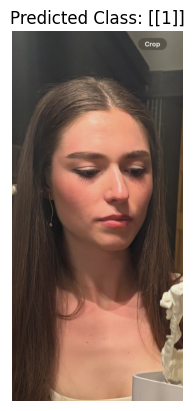

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


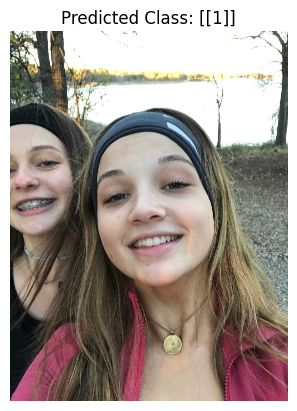

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


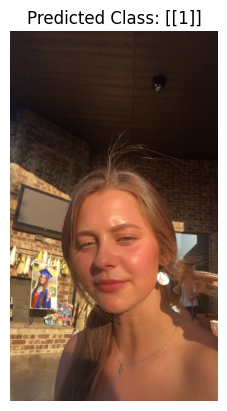

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


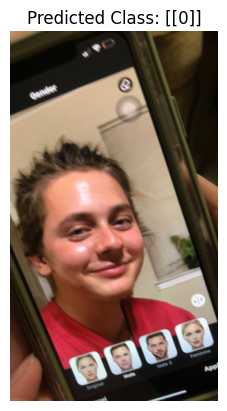

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


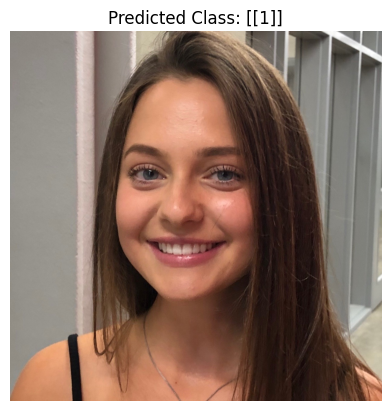

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


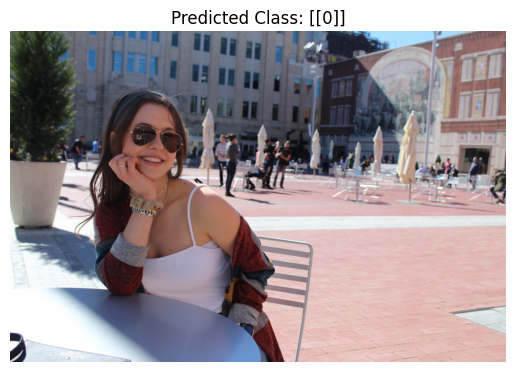

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


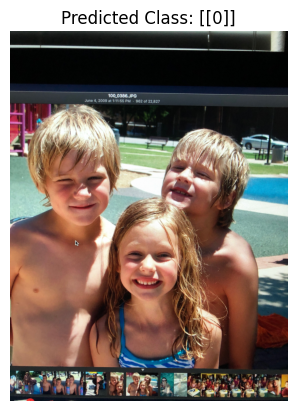

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


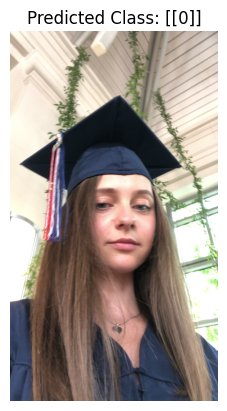

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


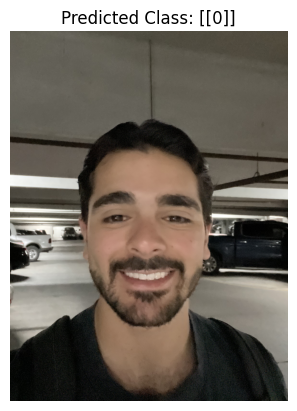

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


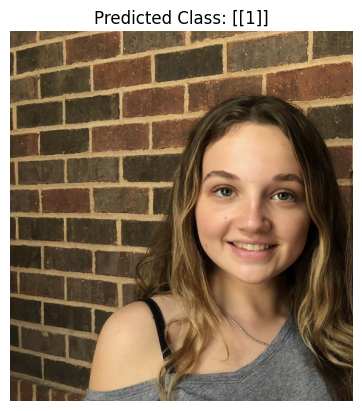

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


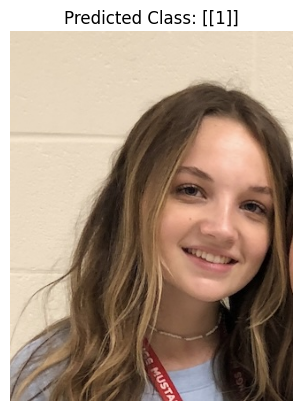

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


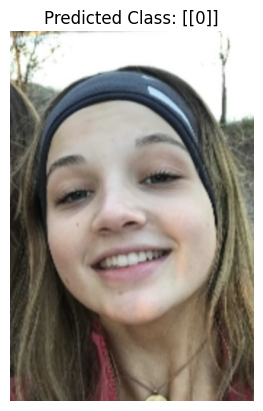

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


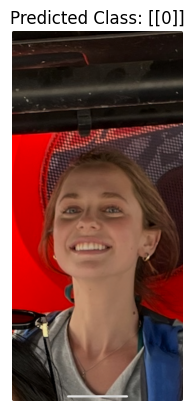

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


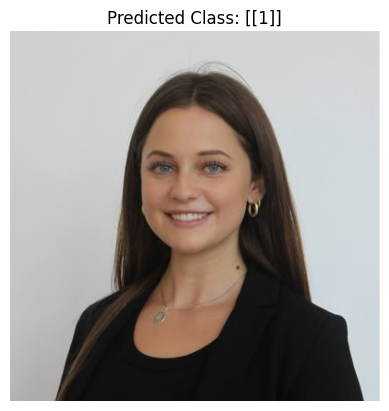

In [53]:
# Load in Positive Class
unseen_set = load_dataset("Test Set")

for i in range(len(unseen_set['train'])):
    img = unseen_set['train']['image'][i]
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class = (prediction > 0.8).astype(int)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {predicted_class}")
    plt.show()